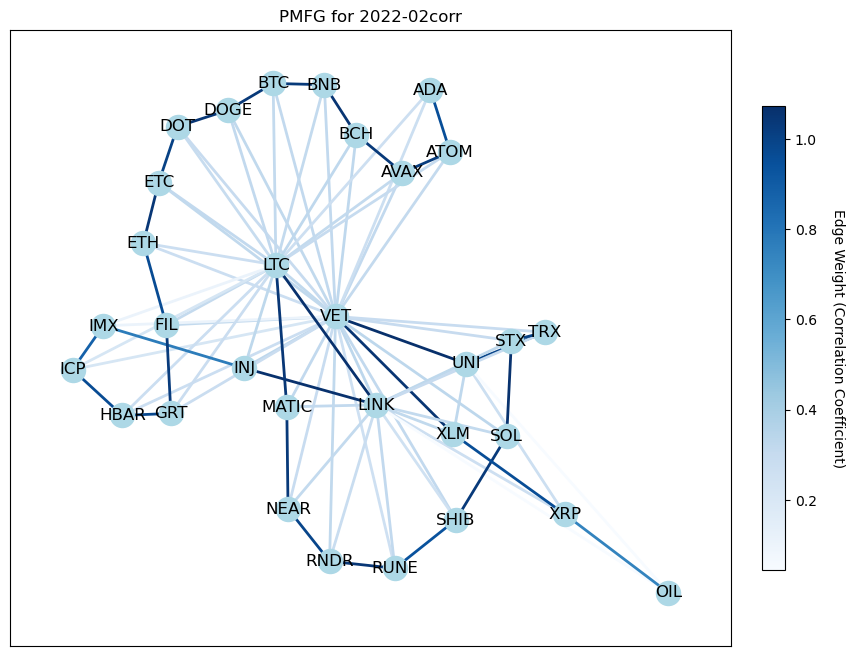

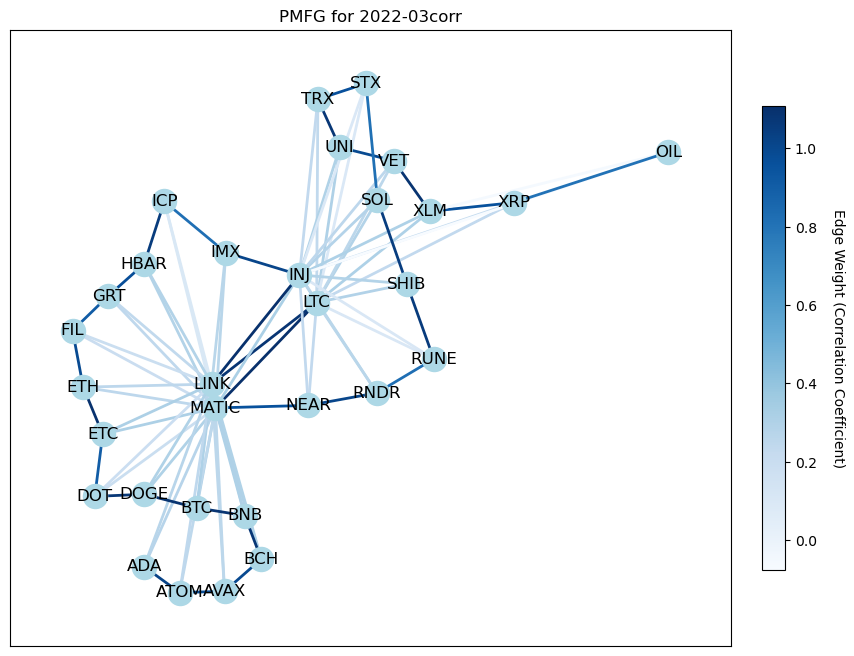

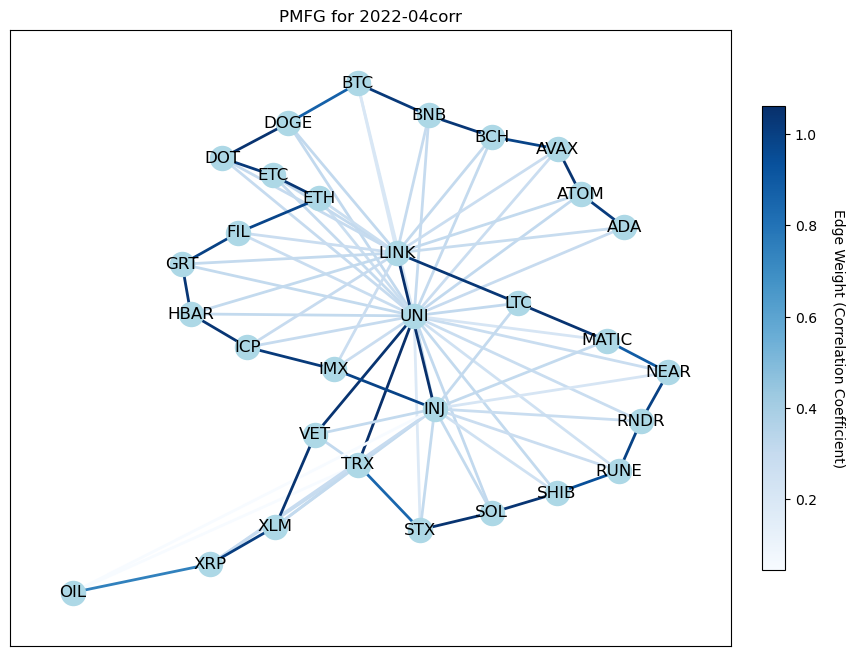

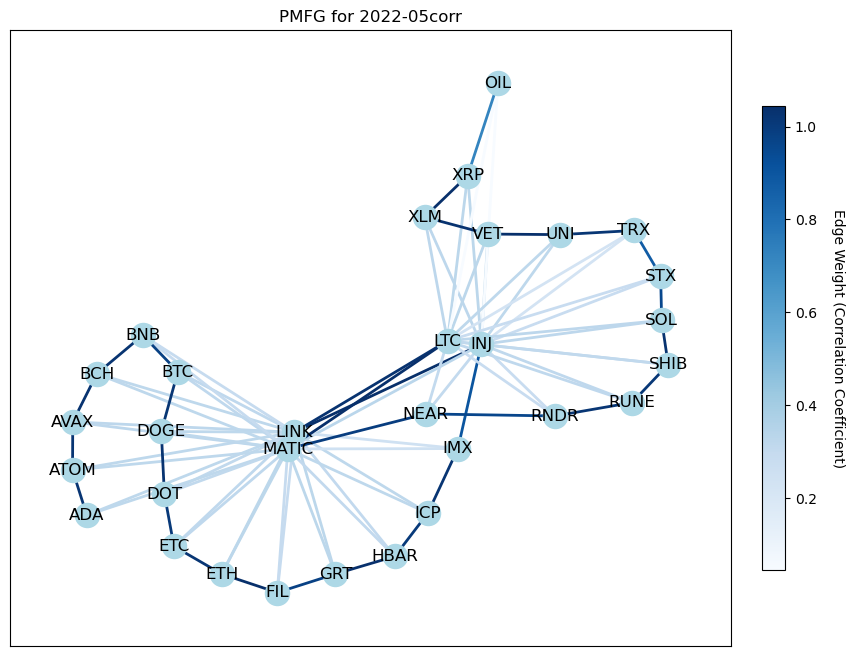

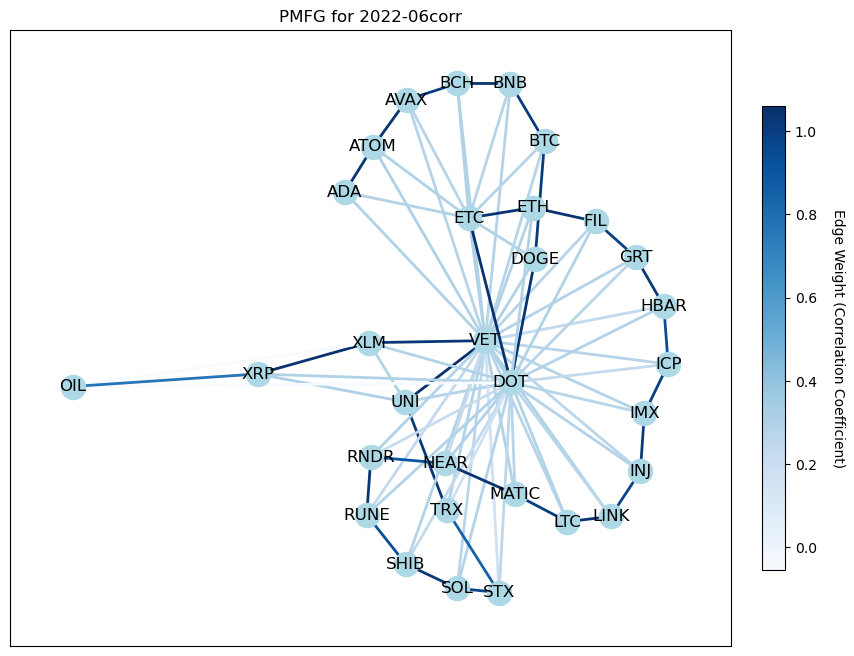

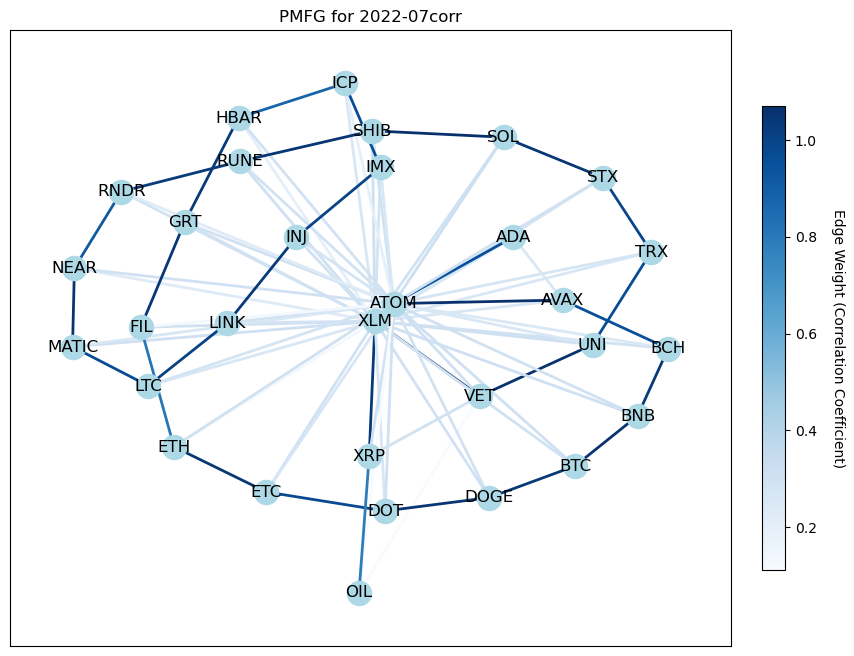

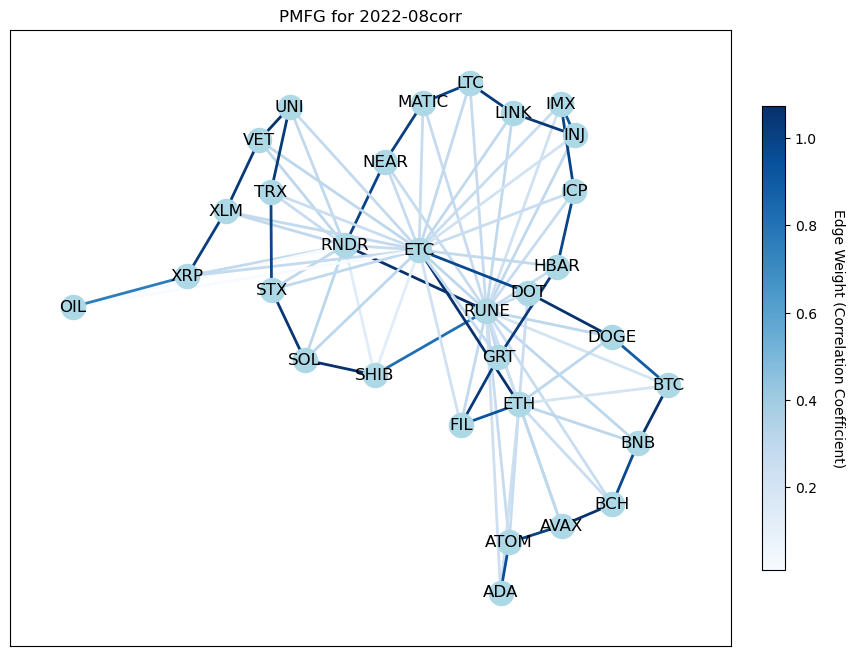

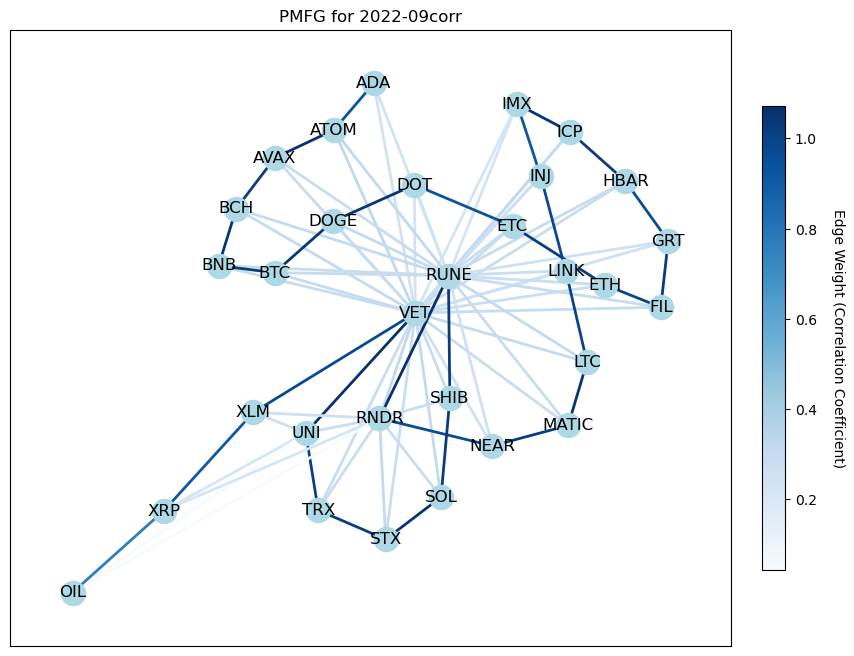

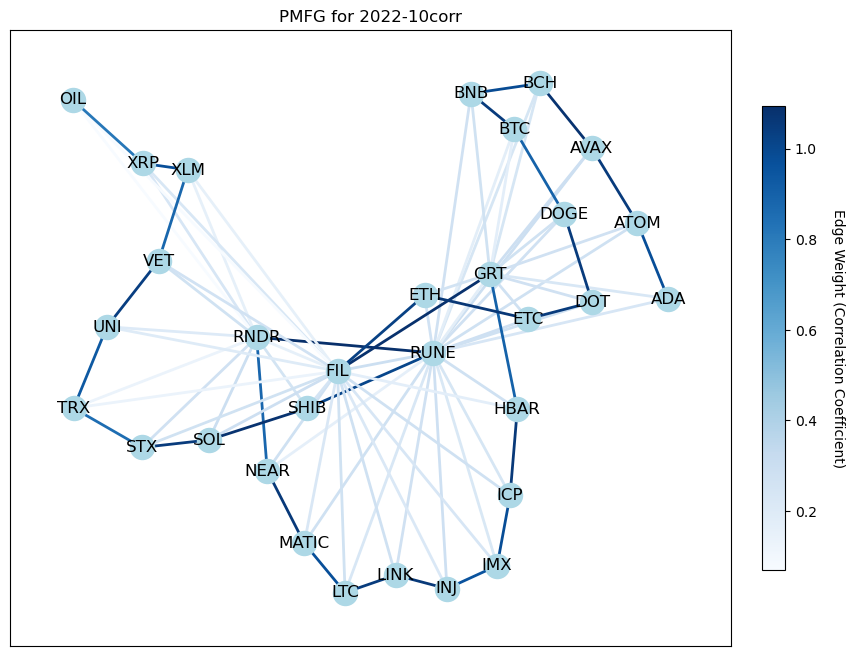

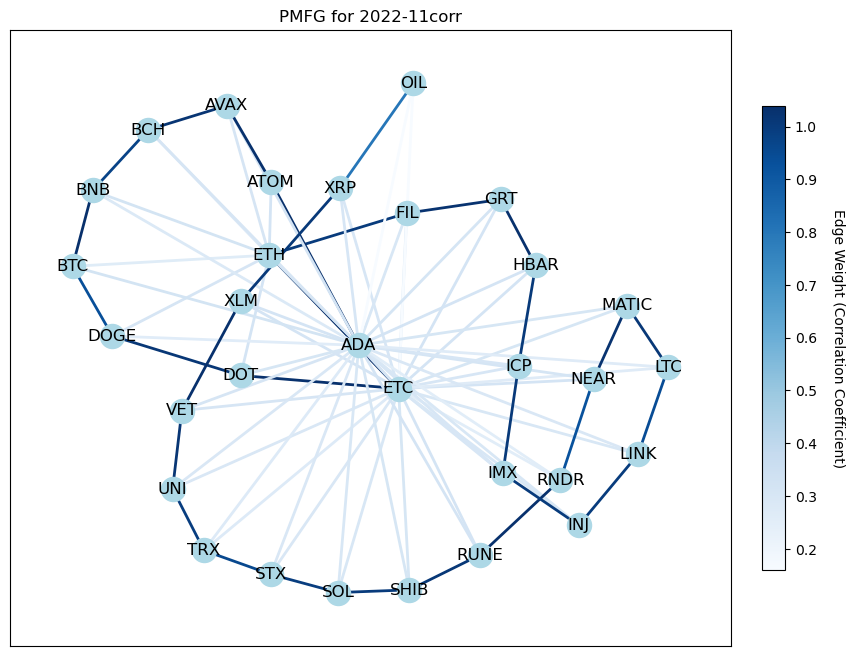

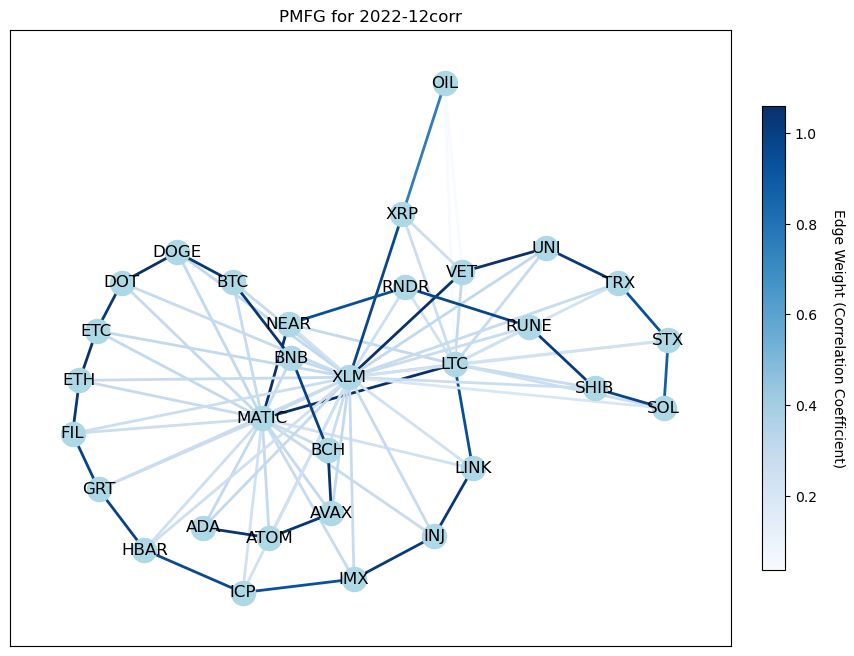

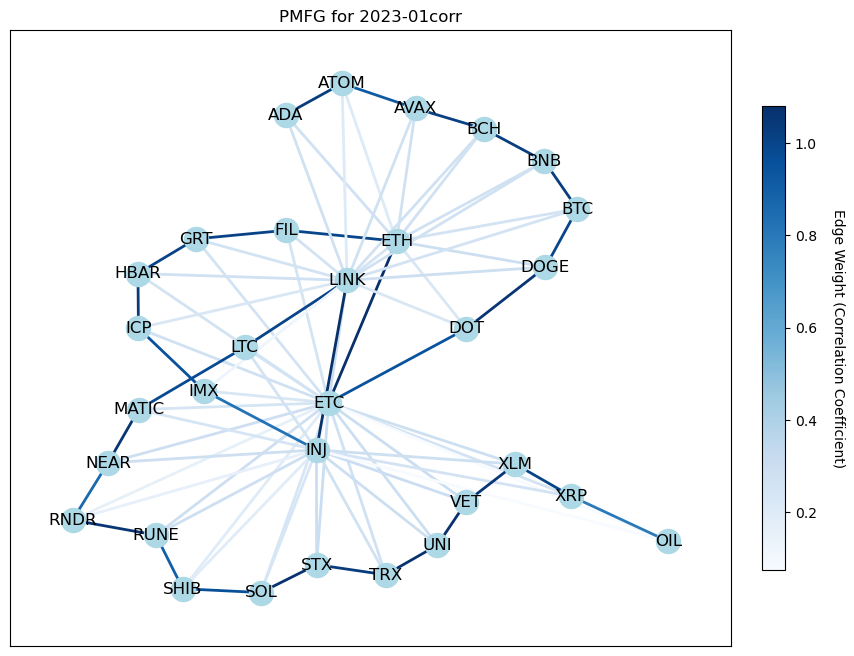

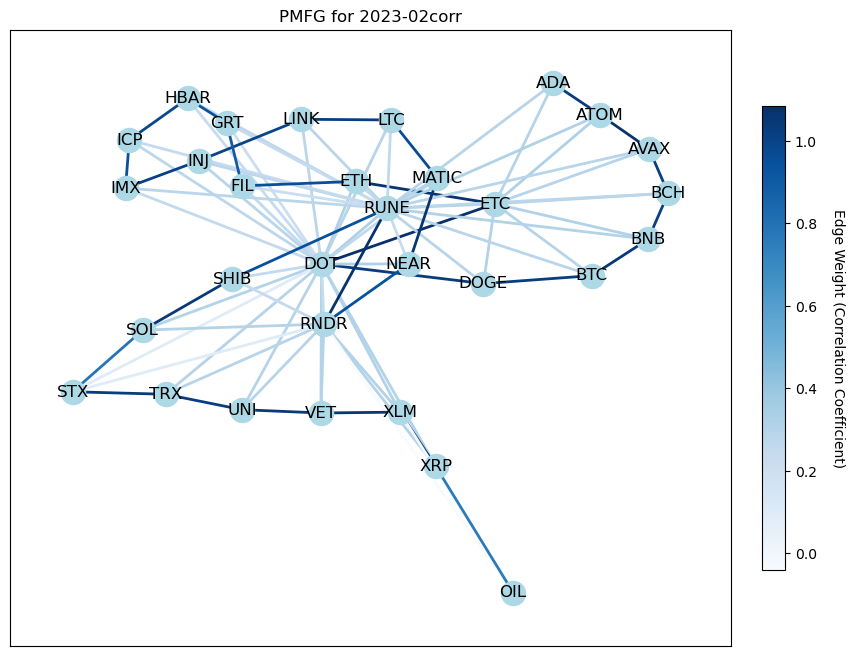

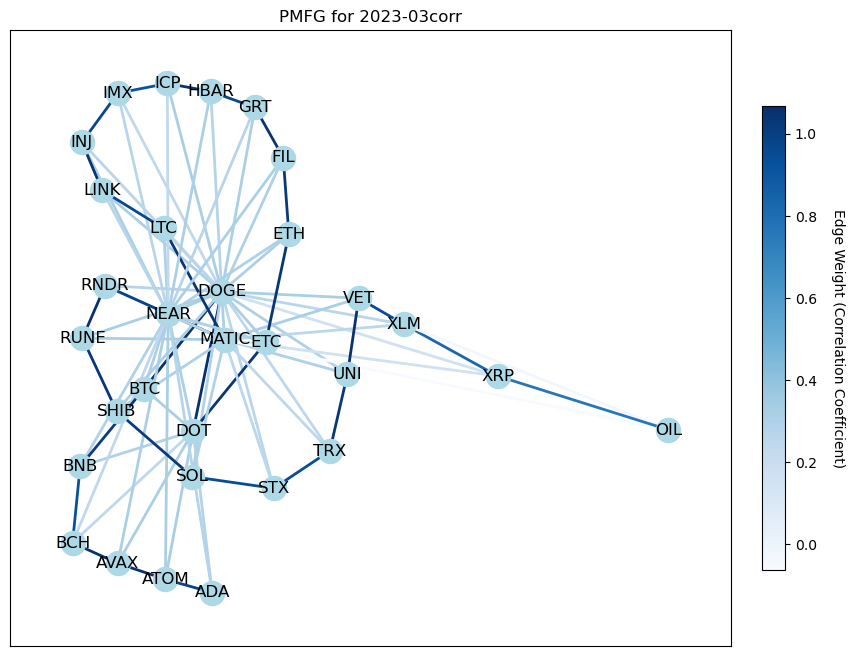

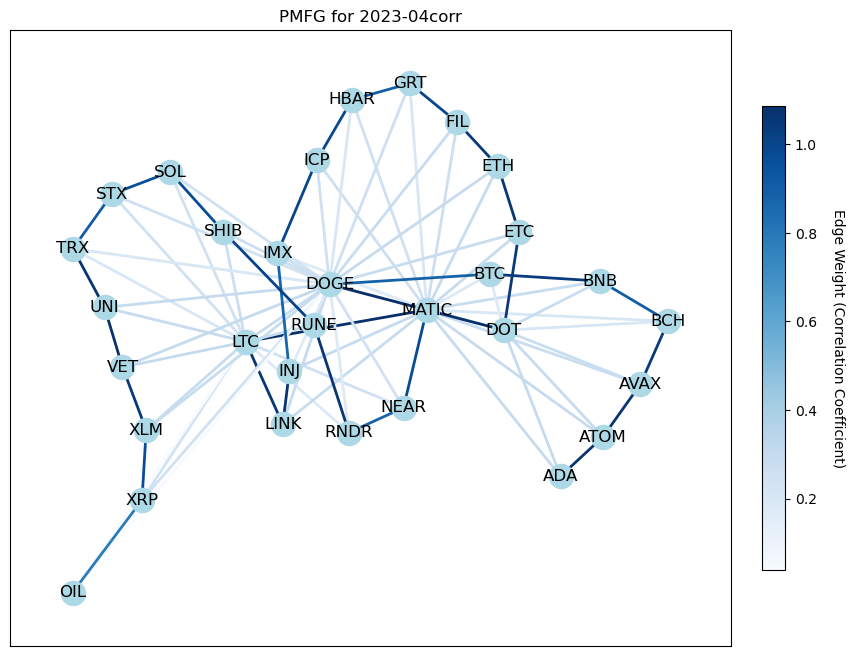

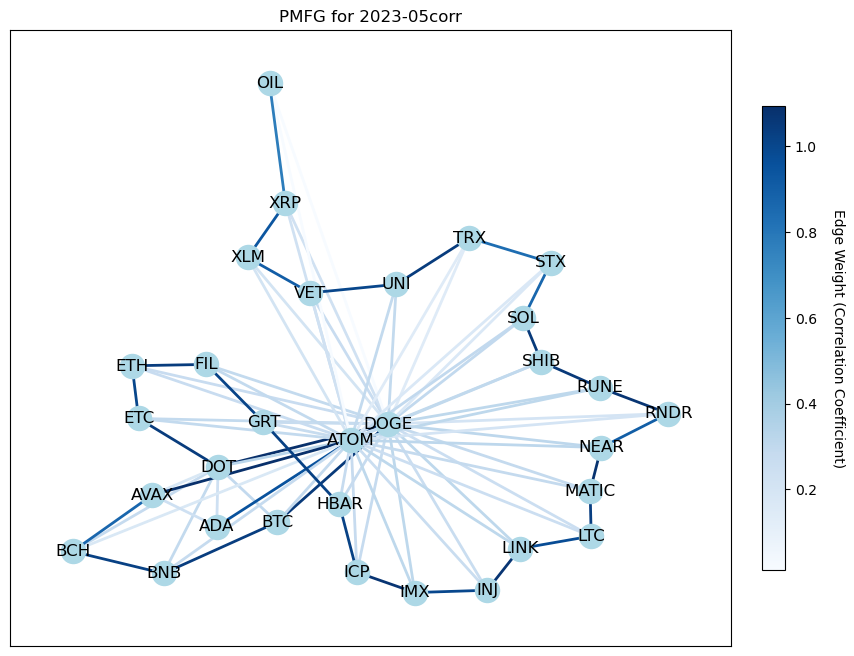

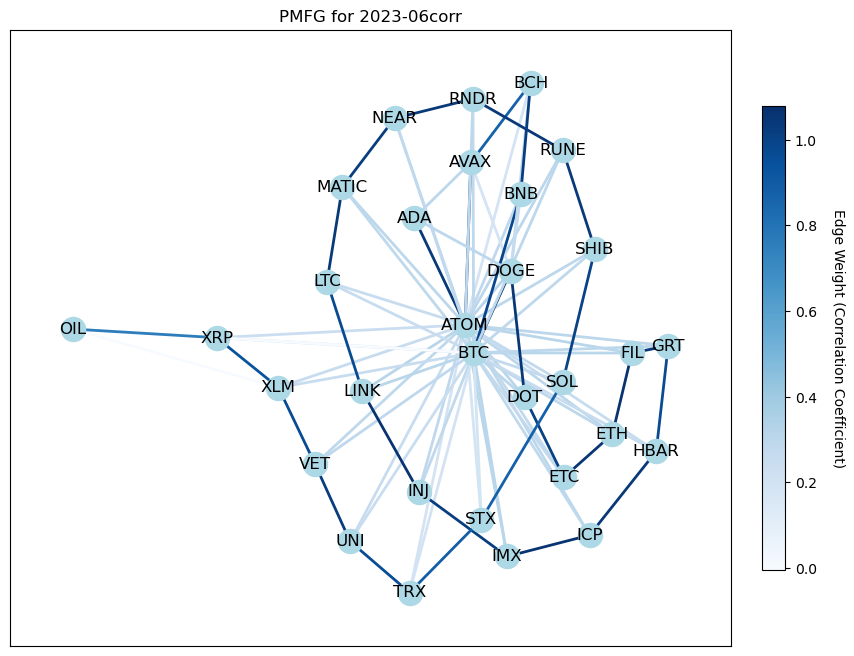

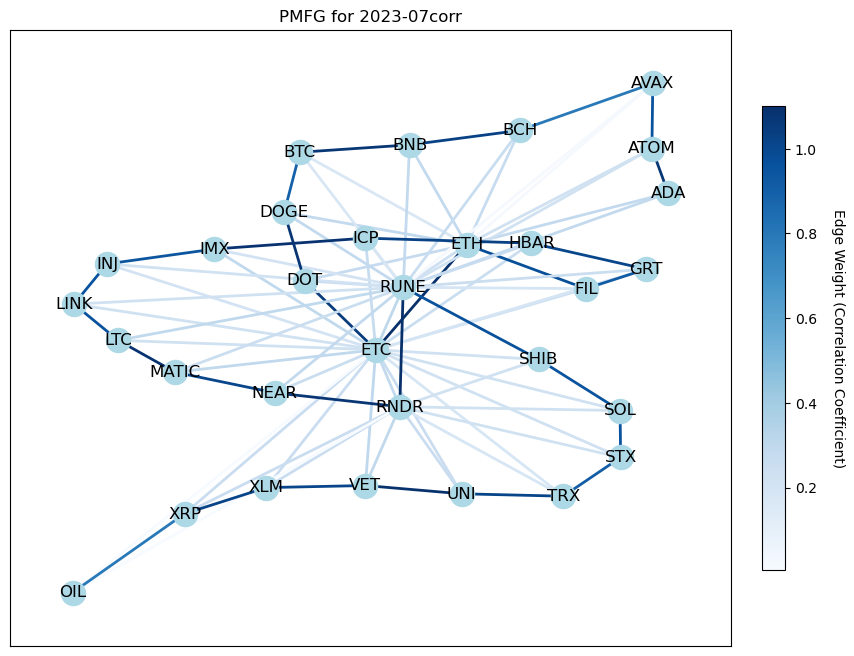

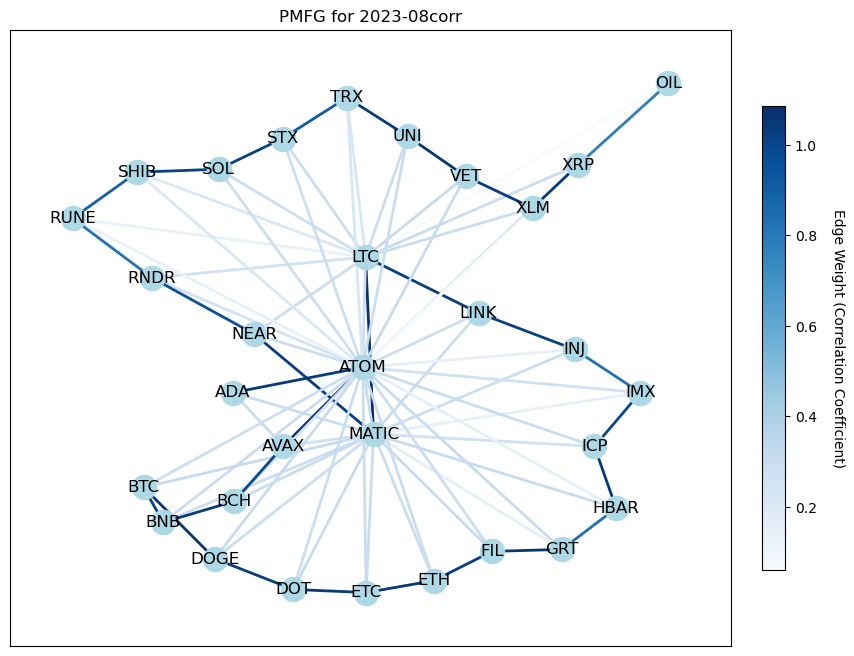

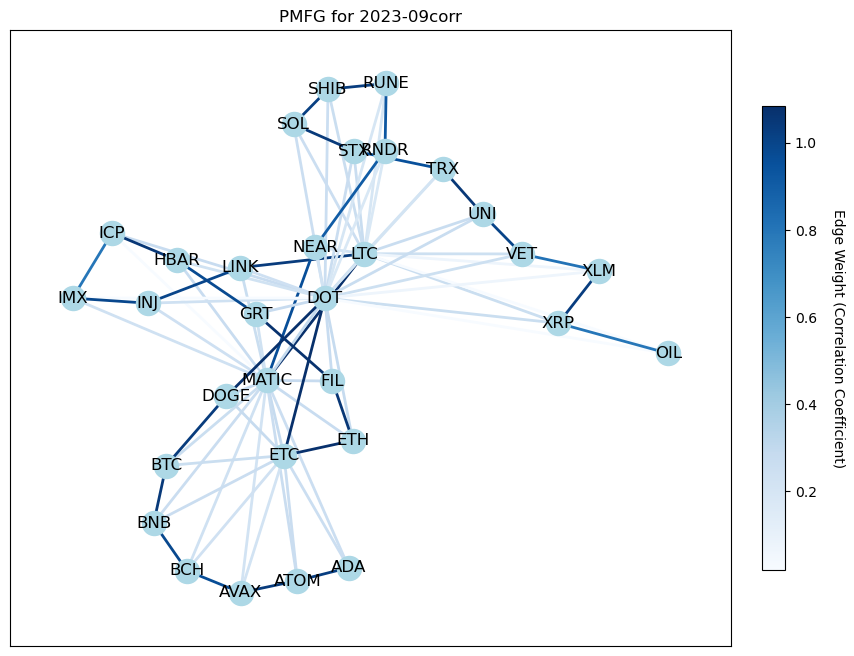

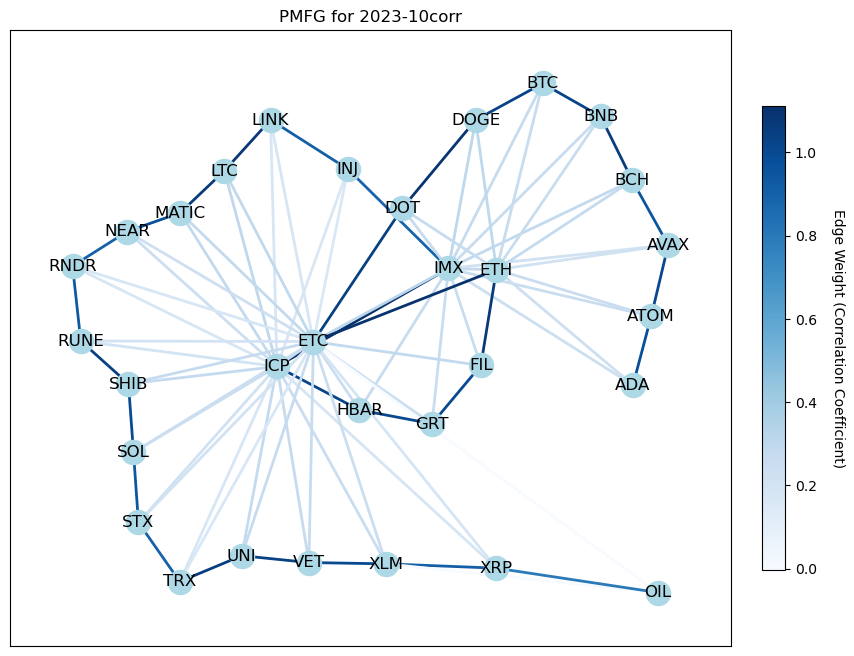

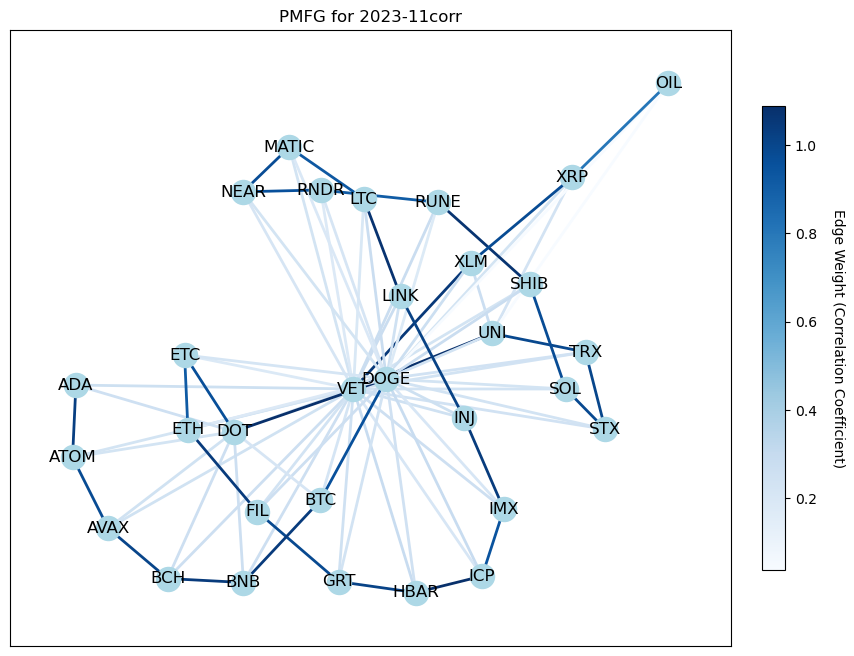

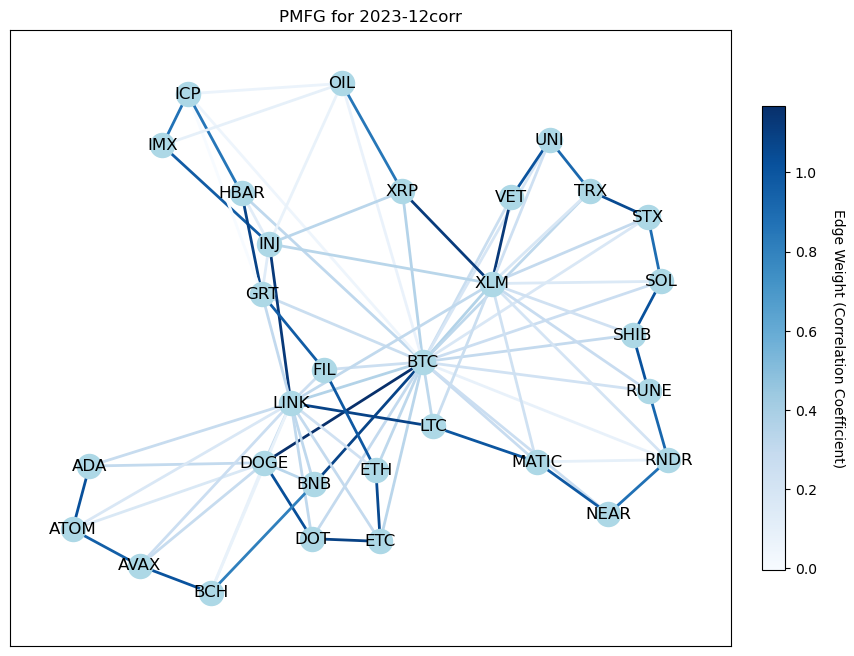

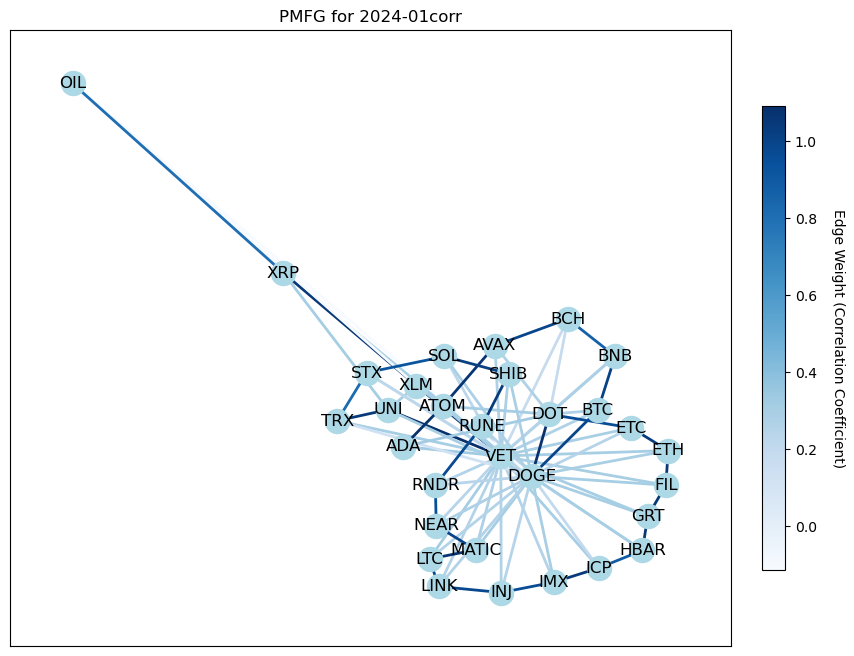

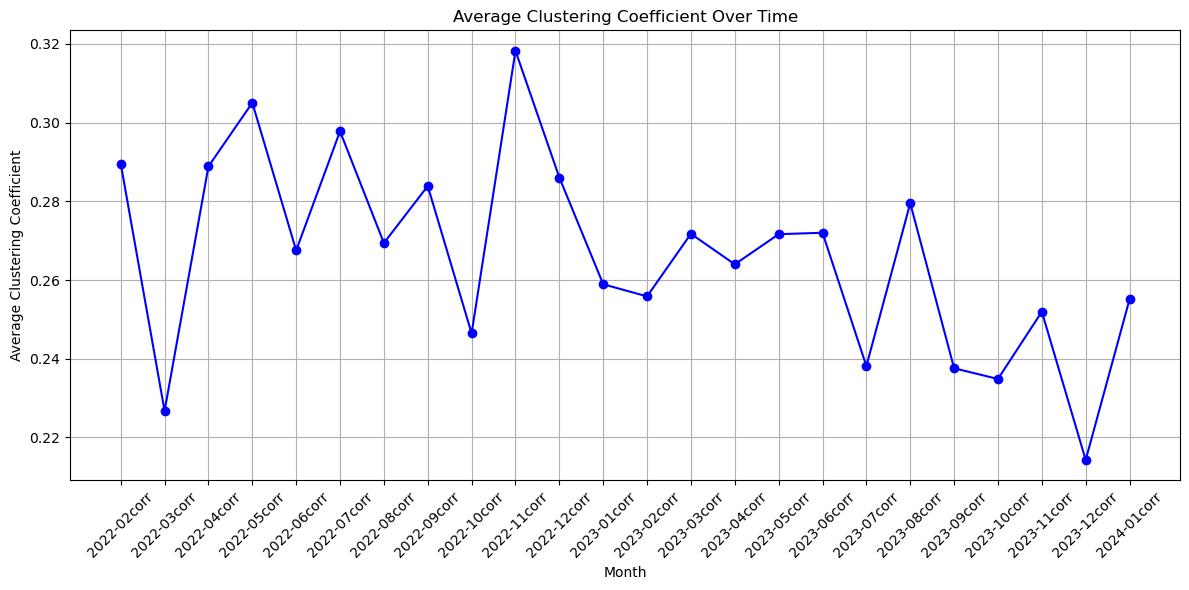

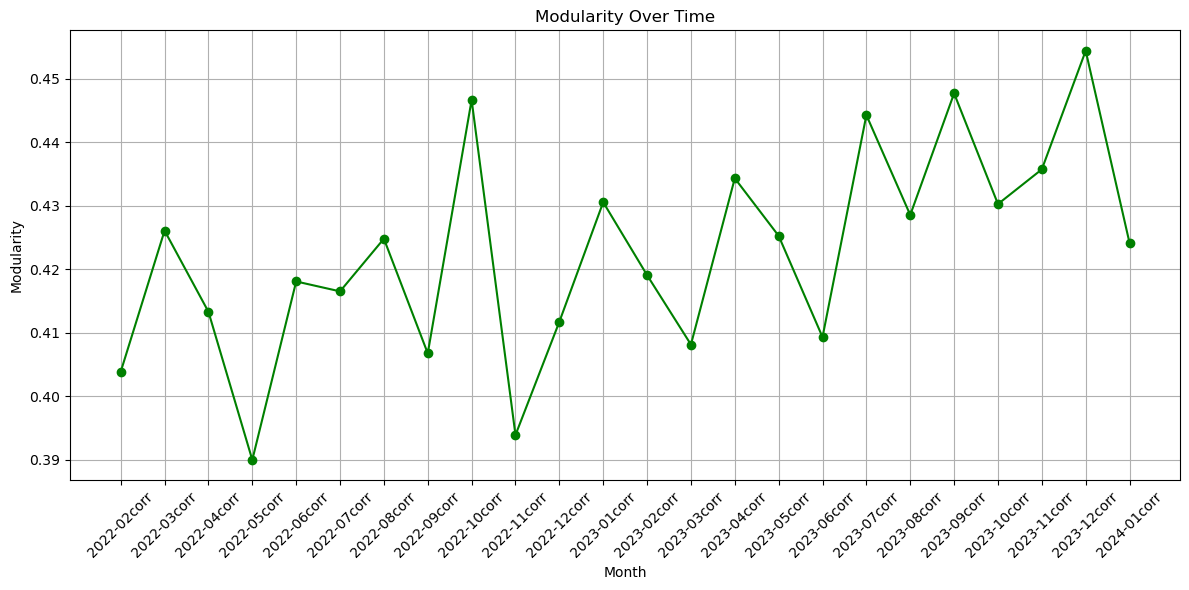

In [97]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from collections import defaultdict

def load_data(sheet_name):
    file_path = '/Users/sihaohuang/Downloads/denoised_correlation_matrices111.xlsx'  # Update this path
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

def construct_pmfg(correlation_matrix, labels):
    G = nx.Graph()
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            # If the correlation value is not zero and neither label corresponds to an empty cell A1
            if correlation_matrix[i][j] != 0 and labels[i] and labels[j]:
                G.add_edge(labels[i], labels[j], weight=correlation_matrix[i][j])

    pmfg = nx.Graph()
    sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    for edge in sorted_edges:
        # Add edge if it doesn't violate planarity and neither node is the 'Unnamed: 0' node
        if edge[0] != 'Unnamed: 0' and edge[1] != 'Unnamed: 0':
            pmfg.add_edge(edge[0], edge[1], weight=edge[2]['weight'])
            if not nx.check_planarity(pmfg)[0]:
                pmfg.remove_edge(edge[0], edge[1])
    return pmfg


def visualize_pmfg(pmfg, title, save_path):
    pos = nx.spring_layout(pmfg)
    weights = [pmfg[u][v]['weight'] for u,v in pmfg.edges()]
    fig, ax = plt.subplots(figsize=(10, 8))
    nx.draw_networkx(pmfg, pos, ax=ax, with_labels=True, node_color='lightblue',
                     edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues,
                     edge_vmin=min(weights), edge_vmax=max(weights))
    plt.title(title)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Edge Weight (Correlation Coefficient)', rotation=270, labelpad=20)
    
    # Save the figure
    plt.savefig(os.path.join(save_path, title.replace(' ', '_') + '.png'))
    plt.show()  # Close the plot to free up memory

def compute_network_metrics(pmfg):
    # Calculate centrality measures
    degree_centrality = np.mean(list(nx.degree_centrality(pmfg).values()))
    betweenness_centrality = np.mean(list(nx.betweenness_centrality(pmfg, weight='weight').values()))
    closeness_centrality = np.mean(list(nx.closeness_centrality(pmfg).values()))
    eigenvector_centrality = np.mean(list(nx.eigenvector_centrality_numpy(pmfg, weight='weight').values()))

    # Community detection using the Clauset-Newman-Moore greedy modularity maximization
    communities = community.greedy_modularity_communities(pmfg, weight='weight')
    modularity = community.modularity(pmfg, communities, weight='weight')

    # Assortativity
    assortativity = nx.degree_assortativity_coefficient(pmfg, weight='weight')

    # Network density
    density = nx.density(pmfg)

    # Edge weight distribution
    edge_weights = [data['weight'] for _, _, data in pmfg.edges(data=True)]
    edge_weight_distribution = np.histogram(edge_weights, bins=10)

    metrics = {
        'degree_centrality': degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'modularity': modularity,
        'assortativity': assortativity,
        'density': density,
        'edge_weight_distribution': edge_weight_distribution[0]  
    }

    return metrics

def plot_metric_over_time(metric_values, metric_name, months, save_path):
    plt.figure(figsize=(12, 6))
    plt.plot(months, metric_values, marker='o', linestyle='-', color='b')
    plt.title(f'{metric_name.replace("_", " ").title()} Over Time')
    plt.xlabel('Month')
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{metric_name}_Over_Time.png'))
    plt.close()  # Close the plot to free up memory

def main():
    graphs_save_path = '/Users/sihaohuang/Desktop/PMFG_Visualisation'  # Update this path to the folder where you want to save the graphs
    if not os.path.exists(graphs_save_path):
        os.makedirs(graphs_save_path)

    file_path = '/Users/sihaohuang/Downloads/denoised_correlation_matrices11.xlsx'
    sheet_names = pd.ExcelFile(file_path).sheet_names
    
    clustering_coeffs = []  # Initialize the list to hold the clustering coefficients
    months = []  # Initialize the list to hold the month names

    # Initialize the dictionaries to hold the metrics for each month
    network_metrics_over_time = defaultdict(list)

    for sheet_name in sheet_names:
        df = load_data(sheet_name)
        correlation_matrix = df.values
        labels = df.columns
        pmfg = construct_pmfg(correlation_matrix, labels)
        
        visualize_pmfg(pmfg, f'PMFG for {sheet_name}', graphs_save_path)

        avg_clust_coeff = nx.average_clustering(pmfg, weight='weight')
        clustering_coeffs.append(avg_clust_coeff)
        months.append(sheet_name)

        metrics = compute_network_metrics(pmfg)
        for key, value in metrics.items():
            network_metrics_over_time[key].append(value)

    # Plot and save the average clustering coefficients over months
    plt.figure(figsize=(12, 6))
    plt.plot(months, clustering_coeffs, marker='o', linestyle='-', color='b')
    plt.title('Average Clustering Coefficient Over Time')
    plt.xlabel('Month')
    plt.ylabel('Average Clustering Coefficient')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_save_path, 'Average_Clustering_Coefficient_Over_Time.png'))
    plt.show()

    # Plot and save the additional metrics over months
    # For simplicity, here we show only the plotting of the modularity values over time
    plt.figure(figsize=(12, 6))
    plt.plot(months, network_metrics_over_time['modularity'], marker='o', linestyle='-', color='g')
    plt.title('Modularity Over Time')
    plt.xlabel('Month')
    plt.ylabel('Modularity')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_save_path, 'Modularity_Over_Time.png'))
    plt.show()

    # Plot and save all metrics over time
    for metric, values in network_metrics_over_time.items():
        if metric != 'edge_weight_distribution':
            plot_metric_over_time(values, metric, sheet_names, graphs_save_path)

    # Plotting edge weight distribution for the last PMFG as an example
    edge_weights = network_metrics_over_time['edge_weight_distribution'][-1]
    plt.figure(figsize=(12, 6))
    plt.hist(edge_weights, bins=range(0, 11), color='skyblue', edgecolor='black')
    plt.title('Edge Weight Distribution (Histogram for the last PMFG)')
    plt.xlabel('Edge Weight (Correlation Coefficient)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(graphs_save_path, 'Edge_Weight_Distribution.png'))
    plt.close()

if __name__ == "__main__":
    main()

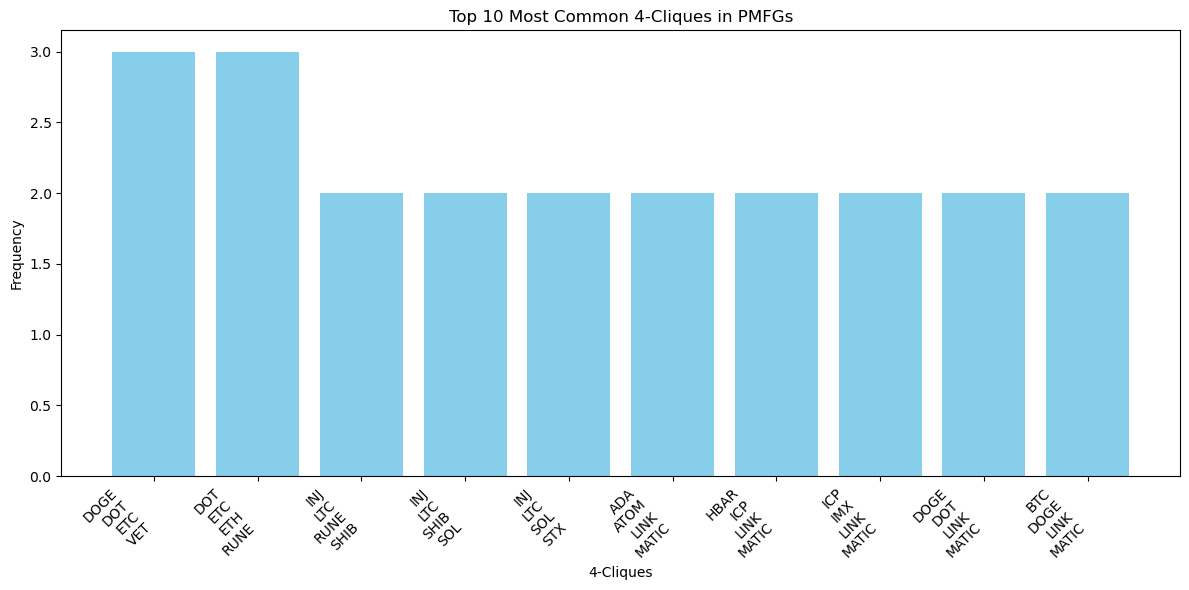

In [94]:
import pandas as pd
import networkx as nx
from collections import Counter
import itertools

def load_data(sheet_name):
    file_path = '/Users/sihaohuang/Downloads/denoised_correlation_matrices111.xlsx'  # Update this path
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

def construct_pmfg(correlation_matrix, labels):
    G = nx.Graph()
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            # If the correlation value is not zero and neither label corresponds to an empty cell A1
            if correlation_matrix[i][j] != 0 and labels[i] and labels[j]:
                G.add_edge(labels[i], labels[j], weight=correlation_matrix[i][j])

    pmfg = nx.Graph()
    sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    for edge in sorted_edges:
        # Add edge if it doesn't violate planarity and neither node is the 'Unnamed: 0' node
        if edge[0] != 'Unnamed: 0' and edge[1] != 'Unnamed: 0':
            pmfg.add_edge(edge[0], edge[1], weight=edge[2]['weight'])
            if not nx.check_planarity(pmfg)[0]:
                pmfg.remove_edge(edge[0], edge[1])
    return pmfg

def find_common_cliques(sheet_names):
    all_cliques = []

    for sheet_name in sheet_names:
        df = load_data(sheet_name)
        correlation_matrix = df.values
        labels = df.columns
        pmfg = construct_pmfg(correlation_matrix, labels)
        
        # Find all 4-cliques
        cliques = list(nx.find_cliques(pmfg))
        four_cliques = [frozenset(clique) for clique in cliques if len(clique) == 4]
        all_cliques.extend(four_cliques)
    
    # Count the cliques
    clique_count = Counter(all_cliques)
    most_common_cliques = clique_count.most_common(10)

    return most_common_cliques

def main():
    file_path = '/Users/sihaohuang/Downloads/denoised_correlation_matrices111.xlsx'
    sheet_names = pd.ExcelFile(file_path).sheet_names  # Update this path
    common_cliques = find_common_cliques(sheet_names)

    # Prepare data for plotting
    cliques_labels = ['\n'.join(sorted(clique)) for clique, _ in common_cliques]
    cliques_counts = [count for _, count in common_cliques]

    # Create the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(cliques_labels, cliques_counts, color='skyblue')

    # Adding labels and title
    plt.xlabel('4-Cliques')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Common 4-Cliques in PMFGs')
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()

if __name__ == "__main__":
    main()

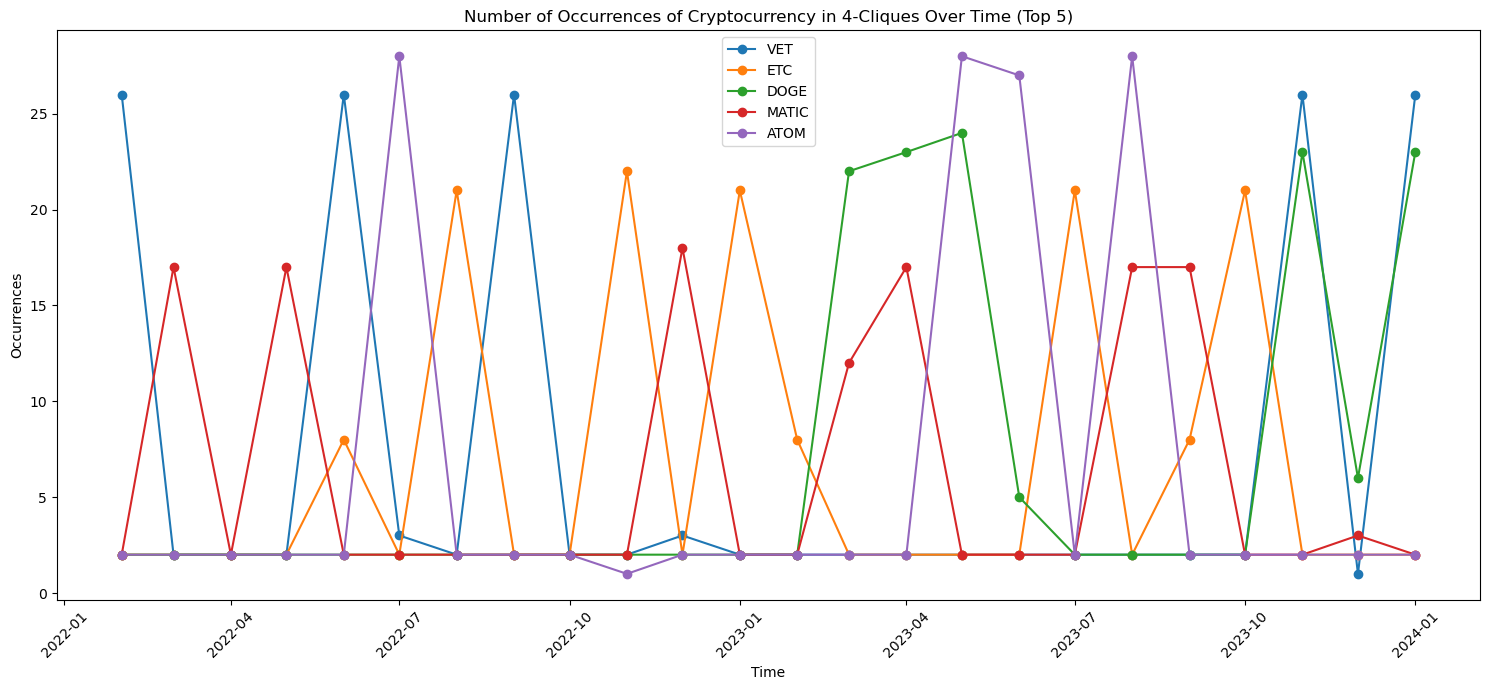

In [95]:
import pandas as pd
import networkx as nx
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

def construct_pmfg(correlation_matrix, labels):
    G = nx.Graph()
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            # If the correlation value is not zero and neither label corresponds to an empty cell A1
            if correlation_matrix[i][j] != 0 and labels[i] and labels[j]:
                G.add_edge(labels[i], labels[j], weight=correlation_matrix[i][j])

    pmfg = nx.Graph()
    sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    for edge in sorted_edges:
        # Add edge if it doesn't violate planarity and neither node is the 'Unnamed: 0' node
        if edge[0] != 'Unnamed: 0' and edge[1] != 'Unnamed: 0':
            pmfg.add_edge(edge[0], edge[1], weight=edge[2]['weight'])
            if not nx.check_planarity(pmfg)[0]:
                pmfg.remove_edge(edge[0], edge[1])
    return pmfg

def parse_dates(sheet_names):
    # Extract dates using regular expression
    dates = []
    for name in sheet_names:
        match = re.search(r'\d{4}-\d{2}', name)
        if match:
            date_str = match.group()
            dates.append(datetime.strptime(date_str, '%Y-%m'))
        else:
            print(f"Date not found in sheet name: {name}")
    return dates

def main():
    file_path = '/Users/sihaohuang/Downloads/denoised_correlation_matrices111.xlsx'
    sheet_names = pd.ExcelFile(file_path).sheet_names
    sheet_dates = parse_dates(sheet_names)

    crypto_occurrences = defaultdict(lambda: defaultdict(int))

    for sheet_name, date in zip(sheet_names, sheet_dates):
        df = load_data(file_path, sheet_name)
        correlation_matrix = df.values
        labels = df.columns.tolist()
        pmfg = construct_pmfg(correlation_matrix, labels)

        cliques = [clique for clique in nx.find_cliques(pmfg) if len(clique) == 4]
        for clique in cliques:
            for crypto in clique:
                crypto_occurrences[crypto][date] += 1

    # Determine the top 10 cryptocurrencies based on total occurrences
    sorted_cryptos = sorted(crypto_occurrences.keys(), key=lambda k: sum(crypto_occurrences[k].values()), reverse=True)
    top_10_cryptos = sorted_cryptos[:5]

    # Plotting the results for the top 10
    plt.figure(figsize=(15, 7))
    for crypto in top_10_cryptos:
        dates, counts = zip(*sorted(crypto_occurrences[crypto].items()))
        plt.plot(dates, counts, label=crypto, marker='o')

    plt.title('Number of Occurrences of Cryptocurrency in 4-Cliques Over Time (Top 5)')
    plt.ylabel('Occurrences')
    plt.xlabel('Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()